# Competition Overview:

In this competition, the goal is to predict answers to real questions about Wikipedia articles. You will use chaii-1, a new question answering dataset with question-answer pairs. The dataset covers Hindi and Tamil, collected without the use of translation. It provides a realistic information-seeking task with questions written by native-speaking expert data annotators. 


# Competition Rules:
- CPU Notebook <= 5 hours run-time
-GPU Notebook <= 5 hours run-time
-Internet access disabled
- Freely & publicly available external data is allowed, including pre-trained models
- Submission file must be named submission.csv

# Competition Metrics:
The metric in this competition is the word-level Jaccard score

`def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))`

### Ref:
- https://keras.io/examples/nlp/text_extraction_with_bert/
- https://github.com/huggingface/notebooks/blob/master/examples/question_answering.ipynb
- https://www.kaggle.com/wchowdhu/hands-on-nli-w-transformers-m-bert-xlm-roberta#Data-Exploration-and-Analysis

### External Datasets
- This Notebook uses @rhtsingh's hindi dataset: [Hindi External](https://www.kaggle.com/rhtsingh/external-data-mlqa-xquad-preprocessing/data)
- For Tamil, the dataset i have created: [Tamil External](https://www.kaggle.com/msafi04/squad-translated-to-tamil-for-chaii)

In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm import tqdm
tqdm.pandas()

import gc

from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from tqdm.auto import tqdm
import collections

import os

from pathlib import Path

import json

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams['axes.titlesize'] = 16
sns.set_palette('Set3_r')

pd.set_option("display.max_rows", 20, "display.max_columns", None)

print(os.listdir('../input/'))
        
from time import time, strftime, gmtime
start = time()
import datetime
print(str(datetime.datetime.now()))

import warnings
warnings.simplefilter(action = 'ignore', category = Warning)

['mlqa-hindi-processed', 'squad-translated-to-tamil-for-chaii', 'chaii-hindi-and-tamil-question-answering', 'jplu-tf-xlm-roberta-large']
2021-09-08 05:53:25.590485


In [2]:
train = pd.read_csv('/kaggle/input/chaii-hindi-and-tamil-question-answering/train.csv')
print(train.shape)
train.head()

(1114, 6)


,id,context,question,answer_text,answer_start,language
0,903deec17,ஒரு சாதாரண வளர்ந்த மனிதனுடைய எலும்புக்கூடு பின...,மனித உடலில் எத்தனை எலும்புகள் உள்ளன?,206,53,tamil
1,d9841668c,காளிதாசன் (தேவநாகரி: कालिदास) சமஸ்கிருத இலக்கி...,காளிதாசன் எங்கு பிறந்தார்?,காசுமீரில்,2358,tamil
2,29d154b56,சர் அலெக்ஸாண்டர் ஃபிளெமிங் (Sir Alexander Flem...,பென்சிலின் கண்டுபிடித்தவர் யார்?,சர் அலெக்ஸாண்டர் ஃபிளெமிங்,0,tamil
3,41660850a,"குழந்தையின் அழுகையை நிறுத்தவும், தூங்க வைக்கவ...",தமிழ்நாட்டில் குழந்தைகளை தூங்க வைக்க பாடும் பா...,தாலாட்டு,68,tamil
4,b29c82c22,சூரியக் குடும்பம் \nசூரியக் குடும்பம் (Solar S...,பூமியின் அருகில் உள்ள விண்மீன் எது?,சூரியனும்,585,tamil


In [3]:
test = pd.read_csv('/kaggle/input/chaii-hindi-and-tamil-question-answering/test.csv')
print(test.shape)
test.head()

(5, 4)


,id,context,question,language
0,22bff3dec,"ज्वाला गुट्टा (जन्म: 7 सितंबर 1983; वर्धा, महा...",ज्वाला गुट्टा की माँ का नाम क्या है,hindi
1,282758170,गूगल मानचित्र (Google Maps) (पूर्व में गूगल लो...,गूगल मैप्स कब लॉन्च किया गया था?,hindi
2,d60987e0e,गुस्ताव रॉबर्ट किरचॉफ़ (१२ मार्च १८२४ - १७ अक्...,गुस्ताव किरचॉफ का जन्म कब हुआ था?,hindi
3,f99c770dc,அலுமினியம் (ஆங்கிலம்: அலுமினியம்; வட அமெரிக்க ...,அலுமினியத்தின் அணு எண் என்ன?,tamil
4,40dec1964,"கூட்டுறவு இயக்க வரலாறு, இங்கிலாந்து நாட்டில் ...",இந்தியாவில் பசுமை புரட்சியின் தந்தை என்று கருத...,tamil


In [4]:
sub = pd.read_csv('/kaggle/input/chaii-hindi-and-tamil-question-answering/sample_submission.csv')
print(sub.shape)
sub.head()

(5, 2)


,id,PredictionString
0,22bff3dec,NaN
1,282758170,NaN
2,d60987e0e,NaN
3,f99c770dc,NaN
4,40dec1964,NaN


In [5]:
external_hindi1 = pd.read_csv('/kaggle/input/mlqa-hindi-processed/mlqa_hindi.csv')
print(external_hindi1.shape)
external_hindi1.head(2)

(5425, 5)


,context,question,answer_text,answer_start,language
0,पैरेनकाइमा कोशिकाएं वे जीवित कोशिकाएं हैं जो स...,एक प्रकार की रस्सी का नाम बताईए जो सेलेरी के क...,कोलेन्काइमा,2267,hindi
1,पैरेनकाइमा कोशिकाएं वे जीवित कोशिकाएं हैं जो स...,क्या चीज पूरी तरह से पैरेनकाइमा कोशिकाओं से बन...,पत्तियां,158,hindi


In [6]:
external_hindi2 = pd.read_csv('/kaggle/input/mlqa-hindi-processed/xquad.csv')
print(external_hindi2.shape)
external_hindi2.head(2)

(1190, 5)


,context,question,answer_text,answer_start,language
0,पैंथर्स की डिफ़ेन्स ने लीग में केवल 308 अंक दिए...,पैंथर्स डिफ़ेंस ने कितने अंक दिए?,308,35,hindi
1,पैंथर्स की डिफ़ेन्स ने लीग में केवल 308 अंक दिए...,जेरेड एलन के पास कितने करियर सैक थे?,136,380,hindi


In [7]:
print('External hindi dataset...')
external_hindi = pd.concat([external_hindi1, external_hindi2])
print(external_hindi.shape)
external_hindi.head()

External hindi dataset...
(6615, 5)


,context,question,answer_text,answer_start,language
0,पैरेनकाइमा कोशिकाएं वे जीवित कोशिकाएं हैं जो स...,एक प्रकार की रस्सी का नाम बताईए जो सेलेरी के क...,कोलेन्काइमा,2267,hindi
1,पैरेनकाइमा कोशिकाएं वे जीवित कोशिकाएं हैं जो स...,क्या चीज पूरी तरह से पैरेनकाइमा कोशिकाओं से बन...,पत्तियां,158,hindi
2,जाइलेम कोशिकाएं कोशिका भित्तियों की लिग्निकृत ...,जाइलेम किस प्रकार के पौधों में पाया जाता है?,ट्रेकियोफाइटों,292,hindi
3,फ्लोएम उच्चतर पौधों में आहार का संवहन करने वाल...,लेप्टोम क्या है?\n,समान कार्य करने वाला एक अधिक सरल ऊतक,969,hindi
4,"सभी हवाई अवयवों की बाह्यत्वचा, जड़ों को छोड़कर...",बाह्यत्वचा की कोशिकाएं क्या कर सकती हैं?,क्यटिन का संश्लेषण,433,hindi


In [8]:
print('External Tamil dataset...')
external_tamil = pd.read_csv('/kaggle/input/squad-translated-to-tamil-for-chaii/squad_translated_tamil.csv')
external_tamil['language'] = 'tamil'
print(external_tamil.shape)
external_tamil.head(2)

External Tamil dataset...
(3567, 5)


,context,question,answer_text,answer_start,language
0,"மாகாணமானது பாரம்பரியமாக ""மீன் மற்றும் அரிசி நி...",மாகாணத்தின் இரண்டாவது முக்கிய பயிர் என்ன?,கோதுமை,133.0,tamil
1,Gregorian சீர்திருத்தம் இரண்டு பகுதிகளைக் கொண்...,சந்திர காலண்டரைப் பயன்படுத்தி என்ன கணக்கிடப்பட...,ஈஸ்டர் தேதி,219.0,tamil


In [9]:
print('Combined External dataset...')
external_df = pd.concat([external_hindi, external_tamil])
external_df = external_df.sample(frac = 1).reset_index(drop = True)
print(external_df.shape)
external_df.head()

Combined External dataset...
(10182, 5)


,context,question,answer_text,answer_start,language
0,தற்போதைய ஐஸ் வயது கடைசி பனிக்கட்டி காலம் சுமார...,கடைசியாக பனிக்கட்டி காலத்தின் முடிவில் கடல் மட...,35 மீட்டர் (115 அடி),142.0,tamil
1,பிரிட்டிஷ் தொலைக்காட்சியில் முக்கிய சோப் ஓபராக...,சோப் ஓபரா Emmerdale க்கு சேனல் என்ன சேனல்?,ITV,140.0,tamil
2,भारत गणराज्य में उन्तीस राज्यों और दो केन्द्र-...,कौन सा संविधान?,भारत,135.0,hindi
3,"அவர் 1922 ஆம் ஆண்டு வரை அவர் இருந்தார், அங்கு ...",ஆபத்தான தொட்டி தந்திரோபாயங்களுக்கான அவரது ஆதரவ...,அவர் கருதினார்,714.0,tamil
4,இறுதியாக 17 பிப்ரவரி 1987 பிப்ரவரி முதல் பாப் ...,எல்டன் ஜான் அவர்களின் கவரேஜ் எத்தனை லிபிட் எழு...,17,9.0,tamil


In [10]:
del external_hindi1, external_hindi2, external_hindi, external_tamil
gc.collect()

20

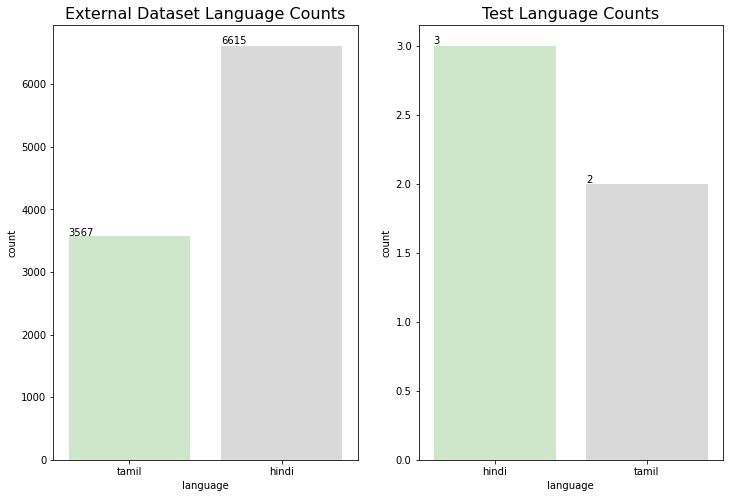

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.countplot(x = 'language', data = external_df, ax = ax1).set_title('External Dataset Language Counts')
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
sns.countplot(x = 'language', data = test, ax = ax2).set_title('Test Language Counts')
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

# Huggingface TF XLM RoBerta
XLM-RoBERTa is a scaled cross lingual sentence encoder. It is trained on 2.5T of data across 100 languages data filtered from Common Crawl. XLM-R achieves state-of-the-arts results on multiple cross lingual benchmarks.

In [12]:
import yaml

hparams = {
    'DEVICE': 'TPU',
    'EPOCHS': 2,
    'MODEL_2': '../input/jplu-tf-xlm-roberta-large',
    'N_FOLDS': 2,
    'SEED': 777,
    'VERBOSE': 1,
    'BATCH_SIZE': 32,
    'MAX_LENGTH': 512,
    'DOC_STRIDE': 128
    
}

In [13]:
import tensorflow as tf
import tensorflow.keras.backend as K

import transformers
from transformers import AutoTokenizer, TFXLMRobertaForQuestionAnswering, TFXLMRobertaModel

print(tf.__version__)
print(transformers.__version__)

2.4.1
4.6.1


In [14]:
SEED = hparams['SEED']
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [15]:
model_checkpoint = hparams['MODEL_2']
batch_size = hparams['BATCH_SIZE']

In [16]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_special_tokens = True)
print(tokenizer)

PreTrainedTokenizerFast(name_or_path='../input/jplu-tf-xlm-roberta-large', vocab_size=250002, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})


In [17]:
train['context_num_tokens'] = train['context'].apply(lambda x: len(tokenizer(x)['input_ids']))
train['context_num_tokens'].max()

14973

<AxesSubplot:>

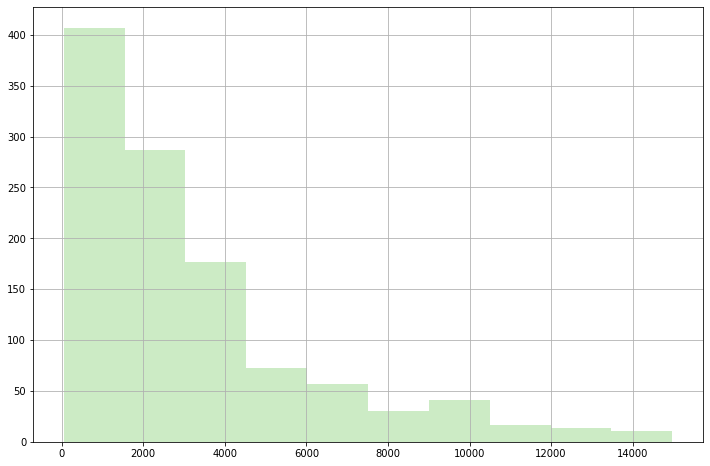

In [18]:
train['context_num_tokens'].hist()

- The context length is too long, it has to be split into pieces before processing
- Usually in NLP tasks long documents are truncated but in QA tasks truncating 'context' would lead to loss of answer
- To avoid this, the long context is split into many input features each of length less than the max_length parameter
- And if answer is at the split, we use overlapping of split features which is controlled by the parameter doc_stride

In [19]:
train = train.sample(frac = 1, random_state = 2021).reset_index(drop = True)
print(train.shape)
train.head()

(1114, 7)


,id,context,question,answer_text,answer_start,language,context_num_tokens
0,0231ad0ec,தமிழ்நாட்டில் மேற்கொள்ளப்படும் வேளாண்மையும் அத...,தமிழ்நாட்டில் அதிகமான ரோஜா பூ எங்கு சாகுபடி செ...,ஓசூர்,1731,tamil,1289
1,80452bc4d,கால்வாய் எனப்படுவது நீர்ப்பாசனத்துக்காக கால்வா...,உலகின் மிகப்பெரிய மனிதனால் உருவாக்கப்பட்ட கால்...,பெரும்,1928,tamil,2778
2,a48ae7027,रजनीकान्त ();(मराठी:शिवाजीराव गायकवाड) एक भारत...,तमिल सिनेमा के अभिनेता रजनीकांत का पूरा नाम क्...,शिवाजीराव गायकवाड,20,hindi,1521
3,6fc07dbd9,"ஜெயமோகன் (Jeyamohan), பிறப்பு: 22 ஏப்ரல் 1962)...",எழுத்தாளர் ஜெயமோகனின் சொந்த ஊர் எது?,"குமரி மாவட்டம் விளவங்கோடு வட்டம், திருவரம்பு",359,tamil,3201
4,33f5a537d,"लीबिया (Arabic: ليبيا‎), आधिकारिक तौर पर 'महान...",लीबिया की राजधानी क्या है?,त्रिपोली,615,hindi,1922


In [20]:
#Split data to folds
n_folds = hparams['N_FOLDS']
train['kfold'] = -1

skf = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = SEED)
for fold, (trn_idx, val_idx) in enumerate(skf.split(X = train, y = train['language'].values)):
    train.loc[val_idx, 'kfold'] = fold
train.head(2)

,id,context,question,answer_text,answer_start,language,context_num_tokens,kfold
0,0231ad0ec,தமிழ்நாட்டில் மேற்கொள்ளப்படும் வேளாண்மையும் அத...,தமிழ்நாட்டில் அதிகமான ரோஜா பூ எங்கு சாகுபடி செ...,ஓசூர்,1731,tamil,1289,1
1,80452bc4d,கால்வாய் எனப்படுவது நீர்ப்பாசனத்துக்காக கால்வா...,உலகின் மிகப்பெரிய மனிதனால் உருவாக்கப்பட்ட கால்...,பெரும்,1928,tamil,2778,1


# Set TPU

In [21]:
DEVICE = 'TPU'

if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
REPLICAS: 8


In [22]:
max_length = hparams['MAX_LENGTH'] #The maximum length of a feature (question and context)
doc_stride = hparams['DOC_STRIDE'] #The authorized overlap between two part of the context when splitting it if needed.

pad_on_right = tokenizer.padding_side == "right"

In [23]:
def prepare_training(examples):
    examples['question'] = [q.lstrip().rstrip('?') for q in examples['question']] #remove leading white space
    
    #Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    #in one example possible giving several features when a context is long, each of those features having a
    #context that overlaps a bit the context of the previous feature.
    
    tokenized_examples = tokenizer(
                list(examples['question' if pad_on_right else 'context'].values),
                list(examples['context' if pad_on_right else 'question'].values),
                truncation = 'only_second' if pad_on_right else 'only_first',
                max_length = max_length,
                stride = doc_stride,
                return_overflowing_tokens = True,
                return_offsets_mapping = True,
                padding = 'max_length'
            )
    #Since one example might give us several features if it has a long context, we need a map from a feature to
    #its corresponding example. This key gives us just that.
    
    sample_mapping = tokenized_examples.pop('overflow_to_sample_mapping')
    
    #The offset mappings will give us a map from token to character position in the original context. This will
    #help us compute the start_positions and end_positions.
    
    offset_mapping = tokenized_examples.pop('offset_mapping')
    
    tokenized_examples['start_positions'] = []
    tokenized_examples['end_positions'] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples['input_ids'][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)
        
        sequence_ids = tokenized_examples.sequence_ids(i)
        
        #One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples.loc[sample_index, 'answer_text']
        start_char = examples.loc[sample_index, 'answer_start']
        
        # If no answers are given, set the cls_index as answer.
        if start_char is None:
            tokenized_examples['start_positions'].append(cls_index)
            tokenized_examples['end_positions'].append(cls_index)
        else:
            # Start/end character idx of the answer in the text.
            end_char = start_char + len(answers)
            
             #Start token idx of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1
            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1
            #Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples['start_positions'].append(cls_index)
                tokenized_examples['end_positions'].append(cls_index)
            else:
                #Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                #Note: we could go after the last offset if the answer is the last word (edge case).
                
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples['start_positions'].append(token_start_index - 1)
                
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples['end_positions'].append(token_end_index + 1)

    return tokenized_examples

In [24]:
def prepare_validation(examples):
    examples['question'] = [q.lstrip() for q in examples['question']]
    examples['question'] = [q.rstrip('?') for q in examples['question']]
    
    tokenized_examples = tokenizer(
                list(examples['question' if pad_on_right else 'context'].values),
                list(examples['context' if pad_on_right else 'question'].values),
                truncation = 'only_second' if pad_on_right else 'only_first',
                max_length = max_length,
                stride = doc_stride,
                return_overflowing_tokens = True,
                return_offsets_mapping = True,
                padding = 'max_length'
            )
    
    sample_mapping = tokenized_examples.pop('overflow_to_sample_mapping')
    
    #id column from the dataset
    tokenized_examples['example_id'] = []

    for i in range(len(tokenized_examples['input_ids'])):
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0
        sample_index = sample_mapping[i]
        tokenized_examples['example_id'].append(examples.loc[sample_index, 'id'])
        tokenized_examples['offset_mapping'][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples['offset_mapping'][i])
        ]

    return tokenized_examples

In [25]:
def build_tf_dataset(df, batch_size = 4, flag = 'train'):
    
    if flag == 'train':
        features = prepare_training(df)
    else:
        features = prepare_validation(df)
    
    input_ids = features['input_ids']
    attn_masks = features['attention_mask']
    
    if flag == 'train':
        start_positions = features['start_positions']
        end_positions = features['end_positions']
        train_dataset = tf.data.Dataset.from_tensor_slices((input_ids, attn_masks, start_positions, end_positions))
        train_dataset = train_dataset.map(lambda x1, x2, y1, y2: ({'input_ids': x1, 'attention_mask': x2}, {'start_positions': y1, 'end_positions': y2}))
        train_dataset = train_dataset.batch(batch_size)
        train_dataset = train_dataset.shuffle(1000)
        train_dataset = train_dataset.prefetch(AUTO)
        
        return train_dataset, features
    
    elif flag == 'valid':
        dataset = tf.data.Dataset.from_tensor_slices((input_ids, attn_masks))
        dataset = dataset.map(lambda x1, x2: ({'input_ids': x1, 'attention_mask': x2}))
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(buffer_size = AUTO)
        
        return dataset, features

# TF XLM RoBerta Model

In [26]:
def build_model():
    roberta = TFXLMRobertaModel.from_pretrained(model_checkpoint)
    
    input_ids = tf.keras.layers.Input(shape = (max_length, ), name = 'input_ids', dtype = tf.int32)
    attention_mask = tf.keras.layers.Input(shape = (max_length, ), name = 'attention_mask', dtype = tf.int32)
    
    embeddings = roberta(input_ids = input_ids, attention_mask = attention_mask)[0]
    
    x1 = tf.keras.layers.Dropout(0.1)(embeddings) 
    x1 = tf.keras.layers.Dense(1, use_bias = False)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax', name = 'start_positions')(x1)
    
    x2 = tf.keras.layers.Dropout(0.1)(embeddings) 
    x2 = tf.keras.layers.Dense(1, use_bias = False)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax', name = 'end_positions')(x2)

    model = tf.keras.models.Model(inputs = [input_ids, attention_mask], outputs = [x1, x2])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-5)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False)
    
    model.compile(loss = [loss, loss], optimizer = optimizer)

    return model

In [27]:
from transformers import logging

logging.set_verbosity(40)

In [28]:
# K.clear_session()
# with strategy.scope():
#     model = build_model()
    
# print(model.summary())

# Metrics

In [29]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

# Post Process Predictions

In [30]:
def post_process_predictions(examples, features, start, end, n_best_size = 20, max_answer_length = 30):
    
    all_start_logits, all_end_logits = start, end
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples['id'])}
    features_per_example = collections.defaultdict(list)
    
    for i, feature in enumerate(features['example_id']):
        features_per_example[example_id_to_index[feature]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features['input_ids'])} features.")

    # Let's loop over all the examples!
    for example_index, example in examples.iterrows():
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]
        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []
        
        context = example['context']
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features['offset_mapping'][feature_index]

            # Update minimum null prediction.
            cls_index = features['input_ids'][feature_index].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key = lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}
        
        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        #if not squad_v2:
        #    predictions[example["id"]] = best_answer["text"]
        #else:
        answer = best_answer["text"] 
        predictions[example['id']] = answer

    return predictions

# Fine Tune Model

In [31]:
t1= time()
print(f" time starting {time()-t1}")
start_probs, end_probs = [], []
jaccard_scores=[]
fold =1
epochs = hparams['EPOCHS']
train_df = train[train['kfold'] != fold]
valid_df = train[train['kfold'] == fold]
#concat external_df to train_df for training, no change in valid_df
train_df = pd.concat([train_df.iloc[:, 1:-1], external_df])
train_df = train_df.reset_index(drop = True)
valid_df = valid_df.reset_index(drop = True) 
train_dataset, train_enc = build_tf_dataset(train_df, batch_size = batch_size, flag = 'train')
valid_dataset, valid_enc = build_tf_dataset(valid_df, batch_size = batch_size, flag = 'valid')
print(f" built all datasets {time()-t1}")

K.clear_session()
with strategy.scope():
    model = build_model()
    
print(f"built model {time()-t1} ")
checkpoint = tf.keras.callbacks.ModelCheckpoint(f'qa_model_{fold + 1}.h5', verbose = 1, monitor = 'loss', mode = 'min', save_best_only = True, 
                                                save_weights_only = True)

history = model.fit(train_dataset, 
                        epochs = 4, 
                        batch_size = batch_size,
                        callbacks = [checkpoint],
                        verbose = 1
                        )
print('Predicting valid dataset...')
start_pred, end_pred = model.predict(valid_dataset, batch_size = batch_size, verbose = 1)
print('Post-process predictions...')
valid_preds = post_process_predictions(valid_df, valid_enc, start_pred, end_pred)
    
score = []
for idx in range(len(valid_df)):
    str1 = valid_df['answer_text'].values[idx]
    str2 = valid_preds[valid_df.loc[idx, 'id']]
    score.append(jaccard(str1, str2))
print(f'Jaccard Score for fold {fold + 1}: {np.mean(score)}')
jaccard_scores.append(np.mean(score))
    
start_probs.append(start_pred)
end_probs.append(end_pred)



 time starting 4.124641418457031e-05
 built all datasets 105.726145029068
built model 199.84664225578308 
Epoch 1/4
493/493 [==============================] - 372s 469ms/step - loss: 5.7645 - start_positions_loss: 2.8042 - end_positions_loss: 2.9603

Epoch 00001: loss improved from inf to 3.95828, saving model to qa_model_2.h5
Epoch 2/4
493/493 [==============================] - 148s 300ms/step - loss: 1.9718 - start_positions_loss: 0.8725 - end_positions_loss: 1.0993

Epoch 00002: loss improved from 3.95828 to 2.01447, saving model to qa_model_2.h5
Epoch 3/4
493/493 [==============================] - 149s 301ms/step - loss: 1.3295 - start_positions_loss: 0.5706 - end_positions_loss: 0.7589

Epoch 00003: loss improved from 2.01447 to 1.38875, saving model to qa_model_2.h5
Epoch 4/4
493/493 [==============================] - 149s 300ms/step - loss: 0.8948 - start_positions_loss: 0.3642 - end_positions_loss: 0.5305

Epoch 00004: loss improved from 1.38875 to 0.92593, saving model to qa_m

In [32]:
# strart_probs, end_probs = [], []
# epochs = hparams['EPOCHS']
# jaccard_scores = []


# for i, fold in enumerate(range(n_folds)):
#     print('=======' * 15)
#     print(f"Fold: {fold + 1}")
#     print('=======' * 15)
#     train_df = train[train['kfold'] != fold]
#     valid_df = train[train['kfold'] == fold]
    
#     #concat external_df to train_df for training, no change in valid_df
#     train_df = pd.concat([train_df.iloc[:, 1:-1], external_df])

#     train_df = train_df.reset_index(drop = True)
#     valid_df = valid_df.reset_index(drop = True)    
#     train_dataset, train_enc = build_tf_dataset(train_df, batch_size = batch_size, flag = 'train')
#     valid_dataset, valid_enc = build_tf_dataset(valid_df, batch_size = batch_size, flag = 'valid')
    
    
#     K.clear_session()
#     with strategy.scope():
#         model = build_model()
#     if i == 0:
#         print(model.summary())
    
#     checkpoint = tf.keras.callbacks.ModelCheckpoint(f'qa_model_{fold + 1}.h5', verbose = 1, monitor = 'loss', mode = 'min', save_best_only = True, 
#                                                 save_weights_only = True)

#     history = model.fit(train_dataset, 
#                         epochs = 3, 
#                         batch_size = batch_size,
#                         callbacks = [checkpoint],
#                         verbose = 1
#                         )
#     print('Predicting valid dataset...')
#     start_pred, end_pred = model.predict(valid_dataset, batch_size = batch_size, verbose = 1)
#     print('Post-process predictions...')
#     valid_preds = post_process_predictions(valid_df, valid_enc, start_pred, end_pred)
    
#     score = []
#     for idx in range(len(valid_df)):
#         str1 = valid_df['answer_text'].values[idx]
#         str2 = valid_preds[valid_df.loc[idx, 'id']]
#         score.append(jaccard(str1, str2))
#     print(f'Jaccard Score for fold {fold + 1}: {np.mean(score)}')
#     jaccard_scores.append(np.mean(score))
    
#     strart_probs.append(start_pred)
#     end_probs.append(end_pred)
    
#     del train_dataset, valid_dataset, model
#     gc.collect()

Save the hyperparameters and the validation scores for prediction notebook

In [33]:
hparams['JAC_SCORES'] = jaccard_scores

with open(r'hparams.yaml', 'w') as f:
    yaml.dump(hparams, f)

# Predict on Test Data

In [34]:
test_dataset, test_enc = build_tf_dataset(test, batch_size = batch_size, flag = 'valid')

In [35]:
start_probs, end_probs = [], []
start_pred, end_pred = model.predict(test_dataset, batch_size = batch_size, verbose = 1)
print(start_pred.shape, end_pred.shape)
start_probs.append(start_pred)
end_probs.append(end_pred)

2/2 [==============================] - 11s 10s/step
(45, 512) (45, 512)


In [36]:
# start_probs, end_probs = [], []
# for fold in range(n_folds):
#     with strategy.scope():
#         model = build_model()
#     print('Loading trained model weights...')
#     model.load_weights(f'qa_model_{fold + 1}.h5')
#     print(f'Predicting testset - Fold: {fold + 1}...')
#     start_pred, end_pred = model.predict(test_dataset, batch_size = batch_size, verbose = 1)
#     print(start_pred.shape, end_pred.shape)
#     start_probs.append(start_pred)
#     end_probs.append(end_pred)

In [37]:
test_start_probs, test_end_probs = np.mean(start_probs, axis = 0), np.mean(end_probs, axis = 0)
predictions = post_process_predictions(test, test_enc, test_start_probs, test_end_probs)

Post-processing 5 example predictions split into 45 features.


In [38]:
sub_df = pd.DataFrame({'id': list(predictions.keys()), 'PredictionString': list(predictions.values())})
sub_df.to_csv('./submission.csv', index = False)
sub_df.head()

,id,PredictionString
0,22bff3dec,येलन
1,282758170,गूगल मानचित्र (Google Maps) (पूर्व में गूगल लो...
2,d60987e0e,१२ मार्च १८२४
3,f99c770dc,13
4,40dec1964,சுவாமிநாதன் மற்றும் வர்கீஸ் குரியன்


Thanks to Kaggle and fellow Kagglers for the all the learnings, nothing beats doing and learning!!!